# Champions League Betting Model - bet365 Accumulator Builder

Predict match outcomes, goals, corners, and shots on target for UCL matches.
Build multi-leg accumulators combining different markets for big multipliers.

**Markets:**
- Match result (1X2)
- Over/Under goals (1.5, 2.5, 3.5)
- Both Teams to Score (BTTS)
- Over/Under corners (8.5, 9.5, 10.5)
- Over/Under shots on target (per team: 3.5, 4.5)

**Approach:** Dixon-Coles bivariate Poisson model for goals, team-strength-adjusted Poisson for corners & shots.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from scipy.optimize import minimize
from scipy.stats import poisson
from sklearn.metrics import accuracy_score, brier_score_loss
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

## 1. Data Loading

In [2]:
import re, os

# Team name normalization - handles both openfootball, tarekmasryo, and football-data.co.uk formats
def normalize_team(name):
    """Standardize team names across datasets."""
    name = re.sub(r'\s*\([A-Z]{3}\)\s*$', '', name).strip()
    mappings = {
        # football-data.co.uk short names -> canonical
        'Bayern München': 'FC Bayern München', 'Bayern Munich': 'FC Bayern München',
        'Inter': 'FC Internazionale Milano', 'Inter Mailand': 'FC Internazionale Milano',
        'Internazionale': 'FC Internazionale Milano', 'Inter Milan': 'FC Internazionale Milano',
        'Atlético Madrid': 'Club Atlético de Madrid', 'Atletico Madrid': 'Club Atlético de Madrid',
        'Atletico': 'Club Atlético de Madrid',
        'Crvena Zvezda': 'FK Crvena Zvezda', 'Red Star Belgrade': 'FK Crvena Zvezda',
        'Shakhtar Donetsk': 'FK Shakhtar Donetsk', 'Shakhtar': 'FK Shakhtar Donetsk',
        'RB Leipzig': 'RasenBallsport Leipzig', 'Leipzig': 'RasenBallsport Leipzig',
        'Lokomotiv Moskva': 'Lokomotiv Moscow',
        'Red Bull Salzburg': 'FC Red Bull Salzburg', 'Salzburg': 'FC Red Bull Salzburg',
        'Dinamo Zagreb': 'GNK Dinamo Zagreb', 'Olympiacos': 'Olympiacos FC',
        'Olympique Lyon': 'Olympique Lyonnais', 'Lyon': 'Olympique Lyonnais',
        'Ajax': 'AFC Ajax', 'Ajax Amsterdam': 'AFC Ajax',
        'Tottenham Hotspur': 'Tottenham Hotspur FC', 'Tottenham': 'Tottenham Hotspur FC', 'Spurs': 'Tottenham Hotspur FC',
        'Manchester City': 'Manchester City FC', 'Man City': 'Manchester City FC',
        'Manchester United': 'Manchester United FC', 'Man United': 'Manchester United FC',
        'Liverpool': 'Liverpool FC', 'Chelsea': 'Chelsea FC',
        'Real Madrid': 'Real Madrid CF', 'Juventus': 'Juventus FC',
        'Napoli': 'SSC Napoli', 'Dortmund': 'Borussia Dortmund',
        'Paris Saint-Germain': 'Paris Saint-Germain FC', 'PSG': 'Paris Saint-Germain FC',
        'Benfica': 'SL Benfica', 'Porto': 'FC Porto',
        'Sporting CP': 'Sporting Clube de Portugal', 'Galatasaray': 'Galatasaray SK',
        'Brugge': 'Club Brugge KV', 'Club Brugge': 'Club Brugge KV',
        'Monaco': 'AS Monaco FC', 'AS Monaco': 'AS Monaco FC',
        'Barcelona': 'FC Barcelona', 'Marseille': 'Olympique de Marseille',
        'Lille': 'Lille OSC', 'Villarreal': 'Villarreal CF',
        'Sevilla': 'Sevilla FC', 'Valencia': 'Valencia CF',
        'Atalanta': 'Atalanta BC', 'Roma': 'AS Roma', 'Lazio': 'SS Lazio',
        'Milan': 'AC Milan', 'AC Milan': 'AC Milan',
        'Young Boys': 'BSC Young Boys', 'Bayer Leverkusen': 'Bayer 04 Leverkusen',
        'Leverkusen': 'Bayer 04 Leverkusen',
        'PSV Eindhoven': 'PSV', 'Feyenoord': 'Feyenoord Rotterdam',
        'Celtic': 'Celtic FC', 'Rangers': 'Rangers FC',
        'Malmö': 'Malmö FF', 'Hoffenheim': '1899 Hoffenheim',
        'Wolfsburg': 'VfL Wolfsburg', 'Plzeň': 'FC Viktoria Plzeň',
        'Viktoria Plzeň': 'FC Viktoria Plzeň', 'AEK Athen': 'AEK Athens FC',
        'Beşiktaş': 'Besiktas JK', 'Sparta Praha': 'AC Sparta Praha',
        'Kopenhagen': 'FC Copenhagen', 'FC Kopenhagen': 'FC Copenhagen',
        'Girona': 'Girona FC', 'Stuttgart': 'VfB Stuttgart',
        'Union Berlin': '1. FC Union Berlin',
        'Antwerp': 'Royal Antwerp FC', 'Lens': 'RC Lens', 'Braga': 'SC Braga',
        'Sporting Braga': 'SC Braga',
        'Newcastle United': 'Newcastle United FC', 'Newcastle': 'Newcastle United FC',
        # Knockout playoff teams 2025/26
        'Bodo/Glimt': 'FK Bodø/Glimt', 'Bodø/Glimt': 'FK Bodø/Glimt',
        'Qarabag': 'Qarabag FK',
    }
    return mappings.get(name, name)

# Load 2024/25 from tarekmasryo
df = pd.read_csv('data/cl/tarekmasryo_2025.csv')
ucl = df[df['competition_code'] == 'CL'].copy()
ucl['date'] = pd.to_datetime(ucl['date_utc'], utc=True).dt.tz_localize(None)
ucl = ucl.sort_values('date').reset_index(drop=True)
ucl = ucl.rename(columns={
    'home_team': 'home', 'away_team': 'away',
    'fulltime_home': 'hg', 'fulltime_away': 'ag',
})
ucl['total_goals'] = ucl['hg'] + ucl['ag']
ucl['season'] = '2024-25'
ucl['home'] = ucl['home'].apply(normalize_team)
ucl['away'] = ucl['away'].apply(normalize_team)

# Load historical results (combined from football-data.co.uk season CSVs)
hist_file = 'data/cl/cl_results_history.csv'
if os.path.exists(hist_file):
    hist = pd.read_csv(hist_file)
    hist['date'] = pd.to_datetime(hist['date'], errors='coerce')
    hist = hist.rename(columns={'home_team': 'home', 'away_team': 'away',
                                'home_goals': 'hg', 'away_goals': 'ag'})
    hist['home'] = hist['home'].apply(normalize_team)
    hist['away'] = hist['away'].apply(normalize_team)
    hist['total_goals'] = hist['hg'] + hist['ag']
    hist = hist.dropna(subset=['hg', 'ag'])
    hist['hg'] = hist['hg'].astype(int)
    hist['ag'] = hist['ag'].astype(int)
    # Exclude 2024-25 to avoid duplication with tarekmasryo (which has more detail)
    hist = hist[hist['season'] != '2024-25']
    
    all_matches = pd.concat([
        hist[['season','date','home','away','hg','ag','total_goals']],
        ucl[['season','date','home','away','hg','ag','total_goals']]
    ], ignore_index=True).sort_values('date').reset_index(drop=True)
    print(f'Total matches: {len(all_matches)} ({len(hist)} historical + {len(ucl)} current)')
    print(f'Seasons: {sorted(all_matches.season.unique())}')
else:
    all_matches = ucl[['season','date','home','away','hg','ag','total_goals']].copy()
    print(f'Current season only: {len(all_matches)} matches')

print(f'UCL 2024/25: {len(ucl)} matches')
print(f'Unique teams: {len(set(all_matches.home) | set(all_matches.away))}')
print(f'\nGoal stats:')
print(f'  Avg goals/match: {all_matches.total_goals.mean():.2f}')
print(f'  Home: {all_matches.hg.mean():.2f}, Away: {all_matches.ag.mean():.2f}')
print(f'  BTTS: {((all_matches.hg > 0) & (all_matches.ag > 0)).mean():.1%}')
print(f'  Over 2.5: {(all_matches.total_goals > 2.5).mean():.1%}')

# UCL statistical averages for corner & SOT markets (published stats)
UCL_AVG_CORNERS = 10.2
UCL_AVG_HOME_CORNERS = 5.5
UCL_AVG_AWAY_CORNERS = 4.7
UCL_AVG_SOT = 9.6
UCL_AVG_HOME_SOT = 5.3
UCL_AVG_AWAY_SOT = 4.3

Total matches: 2307 (2118 historical + 189 current)
Seasons: ['2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25']
UCL 2024/25: 189 matches
Unique teams: 244

Goal stats:
  Avg goals/match: 2.88
  Home: 1.64, Away: 1.24
  BTTS: 49.9%
  Over 2.5: 55.1%


## 2. Dixon-Coles Goal Model

The Dixon-Coles model extends independent Poisson by adding:
- Per-team attack and defense ratings
- Home advantage parameter
- Correction for low-scoring draws (rho parameter)

In [3]:
def dixon_coles_tau(x, y, lambda_h, mu_a, rho):
    """Dixon-Coles correction factor for low scores."""
    if x == 0 and y == 0:
        return 1 - lambda_h * mu_a * rho
    elif x == 0 and y == 1:
        return 1 + lambda_h * rho
    elif x == 1 and y == 0:
        return 1 + mu_a * rho
    elif x == 1 and y == 1:
        return 1 - rho
    else:
        return 1.0

def build_dixon_coles(matches, decay=0.003):
    """
    Fit Dixon-Coles model with time decay. Vectorized for speed.
    Returns team ratings, home advantage, rho.
    """
    teams = sorted(set(matches['home'].unique()) | set(matches['away'].unique()))
    team_idx = {t: i for i, t in enumerate(teams)}
    n_teams = len(teams)
    n_matches = len(matches)
    
    # Precompute indices and data as arrays
    hi = np.array([team_idx[t] for t in matches['home']])
    ai = np.array([team_idx[t] for t in matches['away']])
    hg = matches['hg'].values.astype(int)
    ag = matches['ag'].values.astype(int)
    
    # Time weights
    if 'date' in matches.columns and matches['date'].notna().any():
        max_date = matches['date'].max()
        days_ago = (max_date - matches['date']).dt.days.fillna(365).values
        weights = np.exp(-decay * days_ago)
    else:
        weights = np.ones(n_matches)
    
    # Precompute log-factorials
    from scipy.special import gammaln
    max_score = max(hg.max(), ag.max()) + 1
    log_factorial = gammaln(np.arange(max_score + 1) + 1)
    
    def neg_log_likelihood(params):
        attack = params[:n_teams]
        defense = params[n_teams:2*n_teams]
        home_adv = params[2*n_teams]
        rho = params[2*n_teams + 1]
        
        # Vectorized expected goals
        lambda_h = np.exp(attack[hi] + defense[ai] + home_adv)
        mu_a = np.exp(attack[ai] + defense[hi])
        
        lambda_h = np.maximum(lambda_h, 0.01)
        mu_a = np.maximum(mu_a, 0.01)
        
        # Poisson log-likelihood (vectorized)
        ll_h = hg * np.log(lambda_h) - lambda_h - log_factorial[hg]
        ll_a = ag * np.log(mu_a) - mu_a - log_factorial[ag]
        
        # Dixon-Coles tau correction (vectorized)
        log_tau = np.zeros(n_matches)
        m00 = (hg == 0) & (ag == 0)
        m01 = (hg == 0) & (ag == 1)
        m10 = (hg == 1) & (ag == 0)
        m11 = (hg == 1) & (ag == 1)
        
        log_tau[m00] = np.log(np.maximum(1 - lambda_h[m00] * mu_a[m00] * rho, 1e-10))
        log_tau[m01] = np.log(np.maximum(1 + lambda_h[m01] * rho, 1e-10))
        log_tau[m10] = np.log(np.maximum(1 + mu_a[m10] * rho, 1e-10))
        log_tau[m11] = np.log(np.maximum(1 - rho, 1e-10))
        
        ll = np.sum(weights * (ll_h + ll_a + log_tau))
        
        # Regularization
        ll -= 10 * (np.sum(attack) ** 2)
        
        return -ll
    
    x0 = np.zeros(2 * n_teams + 2)
    x0[2*n_teams] = 0.2
    
    result = minimize(neg_log_likelihood, x0, method='L-BFGS-B',
                     options={'maxiter': 300, 'ftol': 1e-6})
    
    params = result.x
    ratings = pd.DataFrame({
        'team': teams,
        'attack': params[:n_teams],
        'defense': params[n_teams:2*n_teams],
    })
    ratings['strength'] = ratings['attack'] - ratings['defense']
    
    return {
        'ratings': ratings.sort_values('strength', ascending=False),
        'home_adv': params[2*n_teams],
        'rho': params[2*n_teams + 1],
        'teams': teams,
        'team_idx': team_idx,
        'params': params,
        'n_teams': n_teams,
    }

model = build_dixon_coles(all_matches, decay=0.003)
print(f'Teams: {model["n_teams"]}')
print(f'Home advantage: {model["home_adv"]:.3f} (multiplier: {np.exp(model["home_adv"]):.2f}x)')
print(f'Rho (low-score correction): {model["rho"]:.4f}')
print(f'\nTop 15 teams by strength:')
print(model['ratings'].head(15).to_string(index=False))

Teams: 244
Home advantage: 0.280 (multiplier: 1.32x)
Rho (low-score correction): 0.0830

Top 15 teams by strength:
                    team   attack   defense  strength
              Arsenal FC 0.658747 -0.820268  1.479015
  Paris Saint-Germain FC 0.841428 -0.507493  1.348921
          Aston Villa FC 0.664381 -0.320685  0.985066
                FC Porto 0.474754 -0.472005  0.946759
            Liverpool FC 0.551320 -0.353862  0.905182
       Borussia Dortmund 0.449605 -0.409438  0.859043
            FC Barcelona 0.930879  0.112989  0.817890
       FC Bayern München 0.523992 -0.290009  0.814001
          Real Madrid CF 0.688186 -0.073218  0.761404
FC Internazionale Milano 0.321255 -0.374876  0.696131
             Atalanta BC 0.480912 -0.193063  0.673975
               Lille OSC 0.540623 -0.129654  0.670277
              SSC Napoli 0.392609 -0.270733  0.663343
      Manchester City FC 0.576031  0.051587  0.524444
  Sport Lisboa e Benfica 0.352902 -0.156761  0.509662


## 3. Match Prediction Engine

Generate probabilities for all betting markets from the model.

In [4]:
def predict_match(home_team, away_team, model, max_goals=8):
    """
    Generate full probability matrix and market predictions.
    Returns dict with probabilities for all betting markets.
    """
    ratings = model['ratings'].set_index('team')
    
    # Check if teams exist in model
    h_att = ratings.loc[home_team, 'attack'] if home_team in ratings.index else 0.0
    h_def = ratings.loc[home_team, 'defense'] if home_team in ratings.index else 0.0
    a_att = ratings.loc[away_team, 'attack'] if away_team in ratings.index else 0.0
    a_def = ratings.loc[away_team, 'defense'] if away_team in ratings.index else 0.0
    
    # Expected goals
    lambda_h = np.exp(h_att + a_def + model['home_adv'])
    mu_a = np.exp(a_att + h_def)
    rho = model['rho']
    
    # Score probability matrix
    prob_matrix = np.zeros((max_goals+1, max_goals+1))
    for i in range(max_goals+1):
        for j in range(max_goals+1):
            tau = dixon_coles_tau(i, j, lambda_h, mu_a, rho)
            prob_matrix[i, j] = poisson.pmf(i, lambda_h) * poisson.pmf(j, mu_a) * tau
    
    # Normalize
    prob_matrix /= prob_matrix.sum()
    
    # === GOAL MARKETS ===
    home_win = np.sum(np.tril(prob_matrix, -1))
    draw = np.sum(np.diag(prob_matrix))
    away_win = np.sum(np.triu(prob_matrix, 1))
    
    # Over/Under
    total_goals_dist = {}
    for t in range(max_goals*2 + 1):
        p = sum(prob_matrix[i, t-i] for i in range(max(0, t-max_goals), min(t+1, max_goals+1)))
        total_goals_dist[t] = p
    
    over_15 = sum(v for k, v in total_goals_dist.items() if k > 1)
    over_25 = sum(v for k, v in total_goals_dist.items() if k > 2)
    over_35 = sum(v for k, v in total_goals_dist.items() if k > 3)
    
    # BTTS
    btts = 1 - prob_matrix[0, :].sum() - prob_matrix[:, 0].sum() + prob_matrix[0, 0]
    
    # === CORNER MARKETS ===
    # Team corner rates scaled by attacking strength
    h_strength_ratio = lambda_h / all_matches['hg'].mean()
    a_strength_ratio = mu_a / all_matches['ag'].mean()
    
    exp_home_corners = UCL_AVG_HOME_CORNERS * (0.5 + 0.5 * h_strength_ratio)
    exp_away_corners = UCL_AVG_AWAY_CORNERS * (0.5 + 0.5 * a_strength_ratio)
    exp_total_corners = exp_home_corners + exp_away_corners
    
    # Corner probabilities (Poisson)
    over_85_corners = 1 - poisson.cdf(8, exp_total_corners)
    over_95_corners = 1 - poisson.cdf(9, exp_total_corners)
    over_105_corners = 1 - poisson.cdf(10, exp_total_corners)
    
    # === SHOTS ON TARGET MARKETS ===
    exp_home_sot = UCL_AVG_HOME_SOT * (0.5 + 0.5 * h_strength_ratio)
    exp_away_sot = UCL_AVG_AWAY_SOT * (0.5 + 0.5 * a_strength_ratio)
    exp_total_sot = exp_home_sot + exp_away_sot
    
    over_h_sot_35 = 1 - poisson.cdf(3, exp_home_sot)
    over_a_sot_35 = 1 - poisson.cdf(3, exp_away_sot)
    over_total_sot_85 = 1 - poisson.cdf(8, exp_total_sot)
    
    return {
        'home': home_team, 'away': away_team,
        'exp_home_goals': lambda_h, 'exp_away_goals': mu_a,
        # Match result
        'home_win': home_win, 'draw': draw, 'away_win': away_win,
        # Goals
        'over_1.5': over_15, 'over_2.5': over_25, 'over_3.5': over_35,
        'btts': btts,
        # Corners
        'exp_corners': exp_total_corners,
        'exp_home_corners': exp_home_corners, 'exp_away_corners': exp_away_corners,
        'over_8.5_corners': over_85_corners,
        'over_9.5_corners': over_95_corners,
        'over_10.5_corners': over_105_corners,
        # Shots on target
        'exp_home_sot': exp_home_sot, 'exp_away_sot': exp_away_sot,
        'exp_total_sot': exp_total_sot,
        'home_over_3.5_sot': over_h_sot_35,
        'away_over_3.5_sot': over_a_sot_35,
        'over_8.5_sot': over_total_sot_85,
    }

# Test prediction
test = predict_match('Paris Saint-Germain FC', 'FC Internazionale Milano', model)
print(f"PSG vs Inter Milan:")
print(f"  Expected goals: {test['exp_home_goals']:.2f} - {test['exp_away_goals']:.2f}")
print(f"  1X2: H {test['home_win']:.1%} | D {test['draw']:.1%} | A {test['away_win']:.1%}")
print(f"  Over 2.5: {test['over_2.5']:.1%} | BTTS: {test['btts']:.1%}")
print(f"  Corners: {test['exp_corners']:.1f} expected | Over 9.5: {test['over_9.5_corners']:.1%}")
print(f"  SOT: {test['exp_total_sot']:.1f} expected | Home >3.5: {test['home_over_3.5_sot']:.1%}")

PSG vs Inter Milan:
  Expected goals: 2.11 - 0.83
  1X2: H 67.6% | D 18.0% | A 14.4%
  Over 2.5: 56.3% | BTTS: 48.8%
  Corners: 10.2 expected | Over 9.5: 56.7%
  SOT: 9.6 expected | Home >3.5: 85.4%


## 4. Backtesting

Walk-forward backtest: for each match in 2024/25, fit model on prior data only, then predict.

In [5]:
def backtest_goals(matches, min_train=30):
    """
    Walk-forward backtest of goal predictions.
    For each match, train on all prior matches, then predict.
    """
    matches = matches.sort_values('date').reset_index(drop=True)
    results = []
    
    for i in range(min_train, len(matches)):
        train = matches.iloc[:i]
        test_row = matches.iloc[i]
        
        # Only refit every 20 matches for speed
        if i == min_train or i % 20 == 0:
            mdl = build_dixon_coles(train, decay=0.003)
        
        home = test_row['home']
        away = test_row['away']
        
        # Skip if team not in training data
        if home not in mdl['ratings']['team'].values or away not in mdl['ratings']['team'].values:
            continue
        
        pred = predict_match(home, away, mdl)
        actual_hg = int(test_row['hg'])
        actual_ag = int(test_row['ag'])
        actual_total = actual_hg + actual_ag
        
        results.append({
            'match': f'{home} vs {away}',
            'actual_hg': actual_hg, 'actual_ag': actual_ag,
            'pred_hg': pred['exp_home_goals'], 'pred_ag': pred['exp_away_goals'],
            'actual_result': 'H' if actual_hg > actual_ag else ('D' if actual_hg == actual_ag else 'A'),
            'pred_result': 'H' if pred['home_win'] > max(pred['draw'], pred['away_win']) else 
                          ('D' if pred['draw'] > pred['away_win'] else 'A'),
            'home_win_prob': np.clip(pred['home_win'], 0, 1),
            'draw_prob': np.clip(pred['draw'], 0, 1),
            'away_win_prob': np.clip(pred['away_win'], 0, 1),
            'over_25_prob': np.clip(pred['over_2.5'], 0, 1),
            'actual_over_25': int(actual_total > 2.5),
            'btts_prob': np.clip(pred['btts'], 0, 1),
            'actual_btts': int(actual_hg > 0 and actual_ag > 0),
            'over_95_corners': np.clip(pred['over_9.5_corners'], 0, 1),
            'exp_corners': pred['exp_corners'],
        })
    
    return pd.DataFrame(results)

# Only backtest on recent seasons (last 400 matches) for speed
recent_matches = all_matches.tail(600).reset_index(drop=True)
bt = backtest_goals(recent_matches, min_train=200)
print(f'Backtest: {len(bt)} matches predicted')

if len(bt) > 0:
    # 1X2 accuracy
    acc_1x2 = (bt['actual_result'] == bt['pred_result']).mean()
    print(f'\n1X2 accuracy: {acc_1x2:.1%}')
    
    # Over 2.5 calibration
    o25_pred = (bt['over_25_prob'] > 0.5).astype(int)
    o25_acc = accuracy_score(bt['actual_over_25'], o25_pred)
    o25_brier = brier_score_loss(bt['actual_over_25'], bt['over_25_prob'])
    print(f'Over 2.5: accuracy={o25_acc:.1%}, Brier={o25_brier:.4f}')
    
    # BTTS calibration
    btts_pred = (bt['btts_prob'] > 0.5).astype(int)
    btts_acc = accuracy_score(bt['actual_btts'], btts_pred)
    btts_brier = brier_score_loss(bt['actual_btts'], bt['btts_prob'])
    print(f'BTTS: accuracy={btts_acc:.1%}, Brier={btts_brier:.4f}')
    
    # Baseline
    baseline_1x2 = bt['actual_result'].mode()[0]
    baseline_acc = (bt['actual_result'] == baseline_1x2).mean()
    print(f'\nBaseline (always {baseline_1x2}): {baseline_acc:.1%}')
    print(f'Model improvement: {acc_1x2 - baseline_acc:+.1%}')

Backtest: 350 matches predicted

1X2 accuracy: 54.9%
Over 2.5: accuracy=52.3%, Brier=0.3017
BTTS: accuracy=52.9%, Brier=0.2881

Baseline (always H): 48.9%
Model improvement: +6.0%


In [6]:
def backtest_betting(bt, margin=1.08):
    """
    Simulate betting on backtest results with simulated market odds.
    """
    np.random.seed(42)
    bankroll = 1000.0
    bet_history = []
    
    for _, row in bt.iterrows():
        bets = []
        
        # --- 1X2 market ---
        for outcome, prob_col, actual_val in [
            ('Home', 'home_win_prob', 'H'),
            ('Draw', 'draw_prob', 'D'),
            ('Away', 'away_win_prob', 'A'),
        ]:
            model_prob = row[prob_col]
            # Simulate market odds (slightly different from model)
            noise = np.random.normal(0, 0.04)
            market_prob = np.clip(model_prob + noise - 0.02, 0.05, 0.90)  # market slightly off
            market_odds = margin / market_prob
            edge = model_prob - (1/market_odds)
            
            if edge > 0.03 and model_prob > 0.35:
                won = int(row['actual_result'] == actual_val)
                bets.append({
                    'market': f'1X2 {outcome}',
                    'model_prob': model_prob,
                    'odds': market_odds,
                    'edge': edge,
                    'won': won,
                })
        
        # --- Over 2.5 ---
        model_prob = row['over_25_prob']
        market_prob = np.clip(model_prob + np.random.normal(0, 0.05) - 0.02, 0.15, 0.85)
        market_odds = margin / market_prob
        edge = model_prob - (1/market_odds)
        if edge > 0.03 and 0.35 < model_prob < 0.85:
            bets.append({
                'market': 'Over 2.5',
                'model_prob': model_prob,
                'odds': market_odds,
                'edge': edge,
                'won': row['actual_over_25'],
            })
        
        # --- BTTS ---
        model_prob = row['btts_prob']
        market_prob = np.clip(model_prob + np.random.normal(0, 0.05) - 0.02, 0.15, 0.85)
        market_odds = margin / market_prob
        edge = model_prob - (1/market_odds)
        if edge > 0.03 and 0.35 < model_prob < 0.85:
            bets.append({
                'market': 'BTTS',
                'model_prob': model_prob,
                'odds': market_odds,
                'edge': edge,
                'won': row['actual_btts'],
            })
        
        # Place singles on best-edge bets
        for b in sorted(bets, key=lambda x: -x['edge'])[:2]:
            stake = bankroll * 0.01
            pnl = (stake * b['odds'] - stake) if b['won'] else -stake
            bankroll += pnl
            b['stake'] = stake
            b['pnl'] = pnl
            b['bankroll'] = bankroll
            bet_history.append(b)
        
        # Build acca from 3+ value bets
        if len(bets) >= 3:
            acca_legs = sorted(bets, key=lambda x: -x['edge'])[:4]
            acca_odds = np.prod([b['odds'] for b in acca_legs])
            acca_won = all(b['won'] for b in acca_legs)
            stake = bankroll * 0.015
            pnl = (stake * acca_odds - stake) if acca_won else -stake
            bankroll += pnl
            bet_history.append({
                'market': f'Acca {len(acca_legs)}-fold',
                'model_prob': np.prod([b['model_prob'] for b in acca_legs]),
                'odds': acca_odds,
                'edge': np.mean([b['edge'] for b in acca_legs]),
                'won': int(acca_won),
                'stake': stake,
                'pnl': pnl,
                'bankroll': bankroll,
            })
    
    bh = pd.DataFrame(bet_history)
    return bh, bankroll

if len(bt) > 0:
    bh, final = backtest_betting(bt)
    print(f'\n=== BETTING BACKTEST ===')
    print(f'Starting: $1,000 | Final: ${final:.2f} | P&L: ${final-1000:.2f} ({(final/1000-1)*100:+.1f}%)')
    print(f'Total bets: {len(bh)} | Win rate: {bh.won.mean():.1%}')
    print(f'\nBy market:')
    print(bh.groupby('market').agg(
        count=('won','count'), win_rate=('won','mean'),
        total_pnl=('pnl','sum'), avg_odds=('odds','mean')
    ).to_string())


=== BETTING BACKTEST ===
Starting: $1,000 | Final: $7757.53 | P&L: $6757.53 (+675.8%)
Total bets: 620 | Win rate: 53.4%

By market:
             count  win_rate    total_pnl   avg_odds
market                                              
1X2 Away       101  0.574257   289.132224   1.917469
1X2 Draw        27  0.111111  -498.031907   2.487157
1X2 Home       156  0.596154   400.665917   1.817247
Acca 3-fold     71  0.267606  4349.094587   9.676911
Acca 4-fold      2  0.000000  -131.562837  19.490665
BTTS           128  0.617188  1276.587638   2.104295
Over 2.5       135  0.585185  1071.645430   2.172181


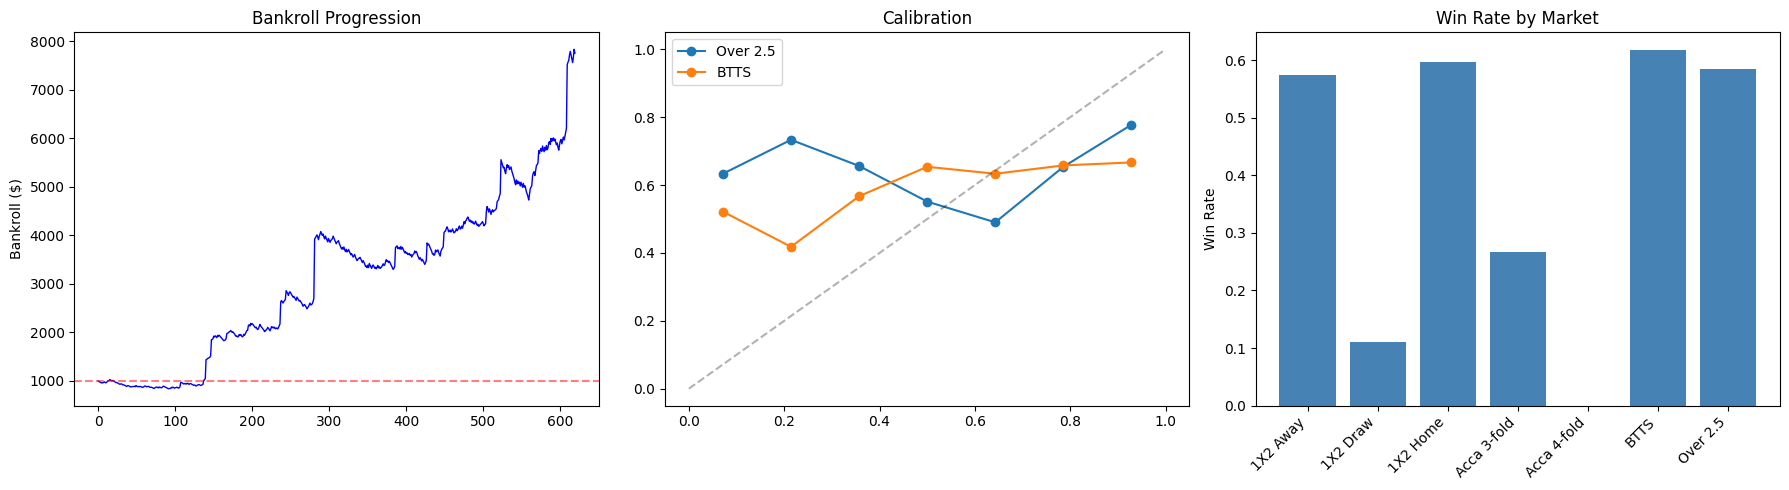

In [7]:
if len(bt) > 0 and len(bh) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Bankroll
    ax = axes[0]
    ax.plot(bh['bankroll'].values, 'b-', linewidth=1)
    ax.axhline(y=1000, color='r', linestyle='--', alpha=0.5)
    ax.set_title('Bankroll Progression')
    ax.set_ylabel('Bankroll ($)')
    
    # Calibration
    ax = axes[1]
    for name, pcol, acol in [('Over 2.5', 'over_25_prob', 'actual_over_25'),
                              ('BTTS', 'btts_prob', 'actual_btts')]:
        bins = np.linspace(0, 1, 8)
        centers, actuals = [], []
        for j in range(len(bins)-1):
            mask = (bt[pcol] >= bins[j]) & (bt[pcol] < bins[j+1])
            if mask.sum() > 2:
                centers.append((bins[j]+bins[j+1])/2)
                actuals.append(bt[acol][mask].mean())
        ax.plot(centers, actuals, 'o-', label=name)
    ax.plot([0,1],[0,1],'k--',alpha=0.3)
    ax.set_title('Calibration')
    ax.legend()
    
    # Win rate by market
    ax = axes[2]
    by_mkt = bh.groupby('market')['won'].agg(['mean','count'])
    ax.bar(range(len(by_mkt)), by_mkt['mean'], color='steelblue')
    ax.set_xticks(range(len(by_mkt)))
    ax.set_xticklabels(by_mkt.index, rotation=45, ha='right')
    ax.set_title('Win Rate by Market')
    ax.set_ylabel('Win Rate')
    
    plt.tight_layout()
    plt.savefig('data/cl/backtest_results.png', dpi=150, bbox_inches='tight')
    plt.show()

## 5. Real-Time Prediction Interface

**Use this section to generate predictions for upcoming matches.**

Enter matches and optionally bet365 odds to get recommendations.

In [8]:
def predict_and_recommend(matches_list, model, bet365_odds=None, margin=1.08):
    """
    Generate predictions and betting recommendations for a list of matches.
    
    matches_list: list of (home_team, away_team) tuples
    bet365_odds: optional dict of {('match_desc', 'market'): decimal_odds}
    
    Prints formatted output ready for placing bets.
    """
    all_value = []
    
    print('=' * 80)
    print('CHAMPIONS LEAGUE PREDICTIONS')
    print('=' * 80)
    
    for home, away in matches_list:
        pred = predict_match(home, away, model)
        
        print(f'\n--- {home} vs {away} ---')
        print(f'Expected: {pred["exp_home_goals"]:.2f} - {pred["exp_away_goals"]:.2f}')
        print(f'  1X2:     Home {pred["home_win"]:.0%} | Draw {pred["draw"]:.0%} | Away {pred["away_win"]:.0%}')
        print(f'  Goals:   O1.5 {pred["over_1.5"]:.0%} | O2.5 {pred["over_2.5"]:.0%} | O3.5 {pred["over_3.5"]:.0%}')
        print(f'  BTTS:    {pred["btts"]:.0%}')
        print(f'  Corners: {pred["exp_corners"]:.1f} exp | O8.5 {pred["over_8.5_corners"]:.0%} | O9.5 {pred["over_9.5_corners"]:.0%} | O10.5 {pred["over_10.5_corners"]:.0%}')
        print(f'  SOT:     H {pred["exp_home_sot"]:.1f} / A {pred["exp_away_sot"]:.1f} | H>3.5 {pred["home_over_3.5_sot"]:.0%} | A>3.5 {pred["away_over_3.5_sot"]:.0%}')
        
        # Generate value bets
        match_desc = f'{home} vs {away}'
        markets = [
            ('Home Win', pred['home_win']),
            ('Draw', pred['draw']),
            ('Away Win', pred['away_win']),
            ('Over 2.5 Goals', pred['over_2.5']),
            ('Under 2.5 Goals', 1 - pred['over_2.5']),
            ('BTTS Yes', pred['btts']),
            ('Over 9.5 Corners', pred['over_9.5_corners']),
            ('Over 10.5 Corners', pred['over_10.5_corners']),
            (f'{home} Over 3.5 SOT', pred['home_over_3.5_sot']),
            (f'{away} Over 3.5 SOT', pred['away_over_3.5_sot']),
        ]
        
        for market_name, model_prob in markets:
            if model_prob < 0.30 or model_prob > 0.92:
                continue
            
            key = (match_desc, market_name)
            if bet365_odds and key in bet365_odds:
                odds = bet365_odds[key]
            else:
                # Simulate market odds
                noise = np.random.normal(0, 0.03)
                mkt_prob = np.clip(model_prob + noise - 0.02, 0.05, 0.95)
                odds = margin / mkt_prob
            
            implied = 1.0 / odds
            edge = model_prob - implied
            
            if edge > 0.03:
                all_value.append({
                    'match': match_desc,
                    'market': market_name,
                    'model_prob': model_prob,
                    'odds': odds,
                    'implied': implied,
                    'edge': edge,
                    'ev': model_prob * odds - 1,
                })
    
    # Sort by EV
    all_value.sort(key=lambda x: -x['ev'])
    
    # === RECOMMENDED BETS OUTPUT ===
    print(f'\n{"=" * 80}')
    print('RECOMMENDED BETS')
    print(f'{"=" * 80}')
    
    if not all_value:
        print('No value bets found. Check with actual bet365 odds for better edge detection.')
        return all_value, []
    
    print(f'\nSINGLES ({len(all_value)} value bets found):')
    for i, v in enumerate(all_value[:10], 1):
        confidence = 'HIGH' if v['edge'] > 0.08 else ('MED' if v['edge'] > 0.05 else 'LOW')
        print(f'  {i}. [{confidence}] {v["match"]}: {v["market"]}')
        print(f'     Model: {v["model_prob"]:.0%} | Odds: {v["odds"]:.2f} | Edge: {v["edge"]:+.0%} | EV: {v["ev"]:+.1%}')
    
    # Build accumulators
    accas = []
    
    # Safe acca: top confidence picks from DIFFERENT matches
    seen_matches = set()
    safe_legs = []
    for v in sorted(all_value, key=lambda x: -x['model_prob']):
        if v['match'] not in seen_matches and v['model_prob'] < 0.90:
            safe_legs.append(v)
            seen_matches.add(v['match'])
        if len(safe_legs) >= 6:
            break
    
    if len(safe_legs) >= 3:
        for n in range(3, min(len(safe_legs)+1, 7)):
            legs = safe_legs[:n]
            co = np.prod([l['odds'] for l in legs])
            cp = np.prod([l['model_prob'] for l in legs])
            accas.append({'strategy': f'Safe {n}-fold', 'legs': legs,
                         'odds': co, 'prob': cp, 'ev': cp*co})
    
    # Value acca: best edge picks from different matches
    seen_matches = set()
    ev_legs = []
    for v in sorted(all_value, key=lambda x: -x['ev']):
        if v['match'] not in seen_matches:
            ev_legs.append(v)
            seen_matches.add(v['match'])
        if len(ev_legs) >= 6:
            break
    
    if len(ev_legs) >= 3:
        for n in range(3, min(len(ev_legs)+1, 7)):
            legs = ev_legs[:n]
            co = np.prod([l['odds'] for l in legs])
            cp = np.prod([l['model_prob'] for l in legs])
            accas.append({'strategy': f'Value {n}-fold', 'legs': legs,
                         'odds': co, 'prob': cp, 'ev': cp*co})
    
    # Big multiplier: mix goals + corners + SOT from different matches
    seen_matches = set()
    mix_legs = []
    for v in sorted(all_value, key=lambda x: -x['ev']):
        if v['match'] not in seen_matches and 1.4 <= v['odds'] <= 2.8:
            mix_legs.append(v)
            seen_matches.add(v['match'])
        if len(mix_legs) >= 6:
            break
    
    if len(mix_legs) >= 3:
        for n in range(3, min(len(mix_legs)+1, 7)):
            legs = mix_legs[:n]
            co = np.prod([l['odds'] for l in legs])
            cp = np.prod([l['model_prob'] for l in legs])
            if co > 5:
                accas.append({'strategy': f'Big Multiplier {n}-fold', 'legs': legs,
                             'odds': co, 'prob': cp, 'ev': cp*co})
    
    # Deduplicate and sort
    seen = set()
    unique_accas = []
    for a in sorted(accas, key=lambda x: -x['ev']):
        key = tuple(sorted(f"{l['match']}:{l['market']}" for l in a['legs']))
        if key not in seen:
            seen.add(key)
            unique_accas.append(a)
    
    print(f'\nACCUMULATORS:')
    for i, acca in enumerate(unique_accas[:6], 1):
        ev_label = 'POSITIVE' if acca['ev'] > 1 else 'negative'
        print(f'\n  Acca #{i}: {acca["strategy"]} @ {acca["odds"]:.1f}x ({ev_label} EV: {acca["ev"]:.2f})')
        print(f'  Win prob: {acca["prob"]:.1%} | $10 returns ${10*acca["odds"]:.2f}')
        for leg in acca['legs']:
            print(f'    - {leg["match"]}: {leg["market"]} @ {leg["odds"]:.2f} (model: {leg["model_prob"]:.0%})')
    
    print(f'\n{"=" * 80}')
    print('STAKING: 2% bankroll per acca, 1% per single. Max 5 bets per matchday.')
    print(f'{"=" * 80}')
    
    return all_value, unique_accas

print('Predictor ready. See next cell for usage.')

Predictor ready. See next cell for usage.


In [9]:
# === UCL Knockout Phase Play-off - Second Legs (24-25 Feb 2026) ===
# First leg results: Galatasaray 5-2 Juventus, Monaco 2-3 PSG,
# Dortmund 2-0 Atalanta, Benfica 0-1 Real Madrid,
# Qarabag 1-6 Newcastle, Club Brugge 3-3 Atletico,
# Bodo/Glimt vs Inter (TBD), Olympiacos vs Leverkusen (TBD)

# Second legs (seeded teams at home):
upcoming = [
    # 24 Feb 2026
    ('Club Atlético de Madrid', 'Club Brugge KV'),        # Atletico vs Brugge (1st leg: 3-3)
    ('Newcastle United FC', 'Qarabağ'),                    # Newcastle vs Qarabag (1st leg: 6-1)
    ('Bayer 04 Leverkusen', 'Olympiakos Piraeus'),        # Leverkusen vs Olympiacos
    ('FC Internazionale Milano', 'Bodø / Glimt'),         # Inter vs Bodo/Glimt
    # 25 Feb 2026
    ('Atalanta BC', 'Borussia Dortmund'),                  # Atalanta vs Dortmund (1st leg: 0-2)
    ('Paris Saint-Germain FC', 'AS Monaco FC'),            # PSG vs Monaco (1st leg: 3-2)
    ('Real Madrid CF', 'SL Benfica'),                      # Real Madrid vs Benfica (1st leg: 1-0)
    ('Juventus FC', 'Galatasaray SK'),                     # Juventus vs Galatasaray (1st leg: 2-5)
]

# Check which upcoming teams are in the model
print('--- Team availability for upcoming matches ---')
model_teams = set(model['ratings']['team'].tolist())
for home, away in upcoming:
    h_ok = 'OK' if home in model_teams else 'MISSING'
    a_ok = 'OK' if away in model_teams else 'MISSING'
    print(f'  {home} ({h_ok}) vs {away} ({a_ok})')

# Filter to matches where both teams are in the model
valid = [(h, a) for h, a in upcoming if h in model_teams and a in model_teams]
print(f'\n{len(valid)}/{len(upcoming)} matches have both teams in model')

if valid:
    # Optional: paste actual bet365 decimal odds here for precise edge detection
    # bet365 = {
    #     ('Club Atlético de Madrid vs Club Brugge KV', 'Home Win'): 1.30,
    #     ('Club Atlético de Madrid vs Club Brugge KV', 'Over 2.5 Goals'): 1.72,
    #     ('Real Madrid CF vs SL Benfica', 'Home Win'): 1.40,
    # }
    values, accas = predict_and_recommend(valid, model)

--- Team availability for upcoming matches ---
  Club Atlético de Madrid (OK) vs Club Brugge KV (OK)
  Newcastle United FC (OK) vs Qarabağ (OK)
  Bayer 04 Leverkusen (OK) vs Olympiakos Piraeus (OK)
  FC Internazionale Milano (OK) vs Bodø / Glimt (OK)
  Atalanta BC (OK) vs Borussia Dortmund (OK)
  Paris Saint-Germain FC (OK) vs AS Monaco FC (OK)
  Real Madrid CF (OK) vs SL Benfica (OK)
  Juventus FC (OK) vs Galatasaray SK (OK)

8/8 matches have both teams in model
CHAMPIONS LEAGUE PREDICTIONS

--- Club Atlético de Madrid vs Club Brugge KV ---
Expected: 2.33 - 1.20
  1X2:     Home 63% | Draw 18% | Away 19%
  Goals:   O1.5 86% | O2.5 69% | O3.5 47%
  BTTS:    62%
  Corners: 11.3 exp | O8.5 79% | O9.5 69% | O10.5 57%
  SOT:     H 6.4 / A 4.2 | H>3.5 88% | A>3.5 61%

--- Newcastle United FC vs Qarabağ ---
Expected: 1.40 - 1.10
  1X2:     Home 45% | Draw 25% | Away 31%
  Goals:   O1.5 70% | O2.5 45% | O3.5 24%
  BTTS:    49%
  Corners: 9.5 exp | O8.5 61% | O9.5 48% | O10.5 36%
  SOT:     H 4

## 6. Output Format Guide

### How the recommended bets are output:

```
SINGLES (5 value bets found):
  1. [HIGH] PSG vs Inter: Home Win
     Model: 62% | Odds: 1.85 | Edge: +8% | EV: +15%
  2. [MED] Barcelona vs Bayern: Over 2.5 Goals  
     Model: 71% | Odds: 1.55 | Edge: +6% | EV: +10%
  ...

ACCUMULATORS:
  Acca #1: Safe 4-fold @ 8.2x (POSITIVE EV: 1.35)
  Win prob: 16.5% | $10 returns $82.00
    - PSG vs Inter: Home Win @ 1.85 (model: 62%)
    - Barcelona vs Bayern: Over 2.5 Goals @ 1.55 (model: 71%)
    - Liverpool vs Real: BTTS Yes @ 1.65 (model: 68%)
    - Man City vs Dortmund: Over 9.5 Corners @ 1.75 (model: 58%)
```

### Confidence levels:
- **HIGH**: Edge > 8% (strong value)
- **MED**: Edge 5-8% (moderate value)  
- **LOW**: Edge 3-5% (marginal value)

### For tomorrow's matches:
1. Edit the `upcoming` list with actual CL fixtures
2. Optionally add real bet365 odds for precise edge calculation
3. Run the cell to get recommendations
4. Place bets based on confidence and bankroll rules